# Progressive Growing GAN (PGGAN)
In this notebook, we will demonstrate the functionality of ``Scheduler`` which enables advanced training schemes such as the progressive training method described in [Karras et al.](https://arxiv.org/pdf/1710.10196.pdf). 
We will train a PGGAN to produce synthetic frontal chest X-ray images where both the generator and the discriminator grow from $4\times4$ to $128\times128$.

### Progressive Growing Strategy
[Karras et al.](https://arxiv.org/pdf/1710.10196.pdf) propose a training scheme in which both the generator and the discriminator progressively grow from a low resolution to a high resolution.
Both networks begin their training based on $4\times4$ images as illustrated below.
![4x4](./Figure/pggan_4x4.png)
Then, both networks progress from $4\times4$ to $8\times8$ by an adding an additional block that contains a couple of convolutional layers.
![8x8](./Figure/pggan_8x8.png)
Both the generator and the discriminator progressively grow until reaching the desired resolution of $1024\times 1024$.
![1024x1024](./Figure/pggan_1024x1024.png)
*Image Credit: [Presentation slide](https://drive.google.com/open?id=1jYlrX4DgTs2VAfRcyl3pcNI4ONkBg3-g)*

### Smooth Transition between Resolutions
However, when growing the networks, the new blocks must be slowly faded into the networks in order to smoothly transition between different resolutions.
For example, when growing the generator from $16\times16$ to $32\times32$, the newly added block of $32\times32$ is slowly faded into the already well trained $16\times16$ network by linearly increasing a fade-factor $\alpha$ from $0$ to $1$.
Once the network is fully transitioned to $32\times32$, the network is trained a bit further to stabilize before growing to $64\times64$.
![grow](./Figure/pggan_smooth_grow.png)
*Image Credit: [PGGAN Paper](https://arxiv.org/pdf/1710.10196.pdf)*

With this progressive training strategy, PGGAN has achieved the state-of-the-art results in producing high fidelity synthetic images.

## Problem Setting
In this PGGAN example, we decided the following:
* 560K images will be used when transitioning from a lower resolution to a higher resolution.
* 560K images will be used when stabilizing the fully transitioned network.
* Initial resolution will be $4\times4$.
* Final resolution will be $128\times128$.

The number of images for both transitioning and stabilizing is equivalent to 5 epochs; the networks would smoothly grow over 5 epochs and would stabilize for 5 epochs. This yields the following schedule for growing both networks:

* From $1^{st}$ epoch to $5^{th}$ epoch: train $4\times4$ resolution
* From $6^{th}$ epoch to $10^{th}$ epoch: transition from $4\times4$ to $8\times8$
* From $11^{th}$ epoch to $15^{th}$ epoch: stabilize $8\times8$
* From $16^{th}$ epoch to $20^{th}$ epoch: transition from $8\times8$ to $16\times16$
* From $21^{st}$ epoch to $25^{th}$ epoch: stabilize $16\times16$
* From $26^{th}$ epoch to $30^{th}$ epoch: transition from $16\times16$ to $32\times32$
* From $31^{st}$ epoch to $35^{th}$ epoch: stabilize $32\times32$

$\cdots$

* From $51^{th}$ epoch to $55^{th}$ epoch: stabilize $128\times128$

In [1]:
import os
import tempfile

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

import fastestimator as fe
from fastestimator.schedule import EpochScheduler
from fastestimator.util import get_num_devices

In [2]:
target_size=128
epochs=55
save_dir=tempfile.mkdtemp()
max_train_steps_per_epoch=None
data_dir=None

In [3]:
# Parameters
epochs = 3
target_size = 8
max_train_steps_per_epoch = 20


## Configure growing parameters

In [4]:
num_grow = np.log2(target_size) - 2
assert num_grow >= 1 and num_grow % 1 == 0, "need exponential of 2 and greater than 8 as target size"
num_phases = int(2 * num_grow + 1)
assert epochs % num_phases == 0, "epoch must be multiple of {} for size {}".format(num_phases, target_size)
num_grow, phase_length = int(num_grow), int(epochs / num_phases)
event_epoch = [1, 1 + phase_length] + [phase_length * (2 * i + 1) + 1 for i in range(1, num_grow)]
event_size = [4] + [2**(i + 3) for i in range(num_grow)]

## Defining Input `Pipeline`

First, we need to download the chest frontal X-ray dataset from the National Institute of Health (NIH); the dataset has over 112,000 images with resolution $1024\times1024$. We use the pre-built ``fastestimator.dataset.nih_chestxray`` API to download these images. A detailed description of the dataset is available [here](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community).

### Note: Please make sure to have a stable internet connection when downloading the dataset for the first time since the size of the dataset is over 40GB.

In [5]:
from fastestimator.dataset.data import nih_chestxray

dataset = nih_chestxray.load_data(root_dir=data_dir)

### Given the images, we need the following preprocessing operations to execute dynamically for every batch:
1. Read the image.
2. Resize the image to the correct size based on the current epoch.
3. Create a lower resolution of the image, which is accomplished by downsampling by a factor of 2 then upsampling by a factor of 2.
4. Rescale the pixels of both the original image and lower resolution image to the range [-1, 1]
5. Convert both the original image and lower resolution image from channel last to channel first
6. Create the latent vector used by the generator

In [6]:
from fastestimator.op import LambdaOp
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop.univariate import ChannelTranspose, Normalize, ReadImage

resize_map = {
    epoch: Resize(image_in="x", image_out="x", height=size, width=size)
    for (epoch, size) in zip(event_epoch, event_size)
}
resize_low_res_map1 = {
    epoch: Resize(image_in="x", image_out="x_low_res", height=size // 2, width=size // 2)
    for (epoch, size) in zip(event_epoch, event_size)
}
resize_low_res_map2 = {
    epoch: Resize(image_in="x_low_res", image_out="x_low_res", height=size, width=size)
    for (epoch, size) in zip(event_epoch, event_size)
}
batch_size_map = {
    epoch: max(512 // size, 4) * get_num_devices() if size <= 512 else 2 * get_num_devices()
    for (epoch, size) in zip(event_epoch, event_size)
}
batch_scheduler = EpochScheduler(epoch_dict=batch_size_map)
pipeline = fe.Pipeline(
    batch_size=batch_scheduler,
    train_data=dataset,
    drop_last=True,
    ops=[
        ReadImage(inputs="x", outputs="x", color_flag="gray"),
        EpochScheduler(epoch_dict=resize_map),
        EpochScheduler(epoch_dict=resize_low_res_map1),
        EpochScheduler(epoch_dict=resize_low_res_map2),
        Normalize(inputs=["x", "x_low_res"], outputs=["x", "x_low_res"], mean=1.0, std=1.0, max_pixel_value=127.5),
        ChannelTranspose(inputs=["x", "x_low_res"], outputs=["x", "x_low_res"]),
        LambdaOp(fn=lambda: np.random.normal(size=[512]).astype('float32'), outputs="z")
    ])

Let's visualize how our `Pipeline` changes image resolution at the different epochs we specified using `Schedulers`. FastEstimator as a ``get_results`` method to aid in this. In order to correctly visualize the output of the `Pipeline`, we need to provide epoch numbers to the `get_results` method: 

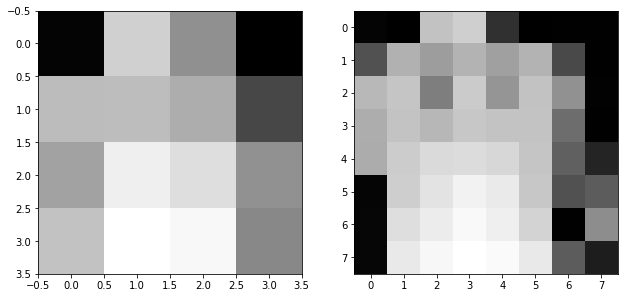

In [7]:
plt.figure(figsize=(50,50))
for i, epoch in enumerate(event_epoch):
    batch_data = pipeline.get_results(epoch=epoch)
    img = np.squeeze(batch_data["x"][0] + 0.5)
    plt.subplot(1, 9, i+1)
    plt.imshow(img, cmap='gray') 

## Defining `Network`
### Defining the generator and the discriminator
To express the progressive growing of networks, we return a list of models that progressively grow from $4 \times 4$ to $1024 \times 1024$ such that $i^{th}$ model in the list is a superset of the previous models. We define a ``fade_in_alpha`` to control the smoothness of growth. ``fe.build`` then bundles each model, optimizer, and model name together for use.

In [8]:
from torch.optim import Adam

def _nf(stage, fmap_base=8192, fmap_decay=1.0, fmap_max=512):
    return min(int(fmap_base / (2.0**(stage * fmap_decay))), fmap_max)


class EqualizedLRDense(torch.nn.Linear):
    def __init__(self, in_features, out_features, gain=np.sqrt(2)):
        super().__init__(in_features, out_features, bias=False)
        torch.nn.init.normal_(self.weight.data, mean=0.0, std=1.0)
        self.wscale = np.float32(gain / np.sqrt(in_features))

    def forward(self, x):
        return super().forward(x) * self.wscale


class ApplyBias(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.bias = torch.nn.Parameter(torch.Tensor(in_features))
        torch.nn.init.constant_(self.bias.data, val=0.0)

    def forward(self, x):
        if len(x.shape) == 4:
            x = x + self.bias.view(1, -1, 1, 1).expand_as(x)
        else:
            x = x + self.bias
        return x


class EqualizedLRConv2D(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros', gain=np.sqrt(2)):
        super().__init__(in_channels, out_channels, kernel_size, padding=padding, padding_mode=padding_mode, bias=False)
        torch.nn.init.normal_(self.weight.data, mean=0.0, std=1.0)
        fan_in = np.float32(np.prod(self.weight.data.shape[1:]))
        self.wscale = np.float32(gain / np.sqrt(fan_in))

    def forward(self, x):
        return super().forward(x) * self.wscale


def pixel_normalization(x, eps=1e-8):
    return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdims=True) + eps)


def mini_batch_std(x, group_size=4, eps=1e-8):
    b, c, h, w = x.shape
    group_size = min(group_size, b)
    y = x.reshape((group_size, -1, c, h, w))  # [G, M, C, H, W]
    y -= torch.mean(y, dim=0, keepdim=True)  # [G, M, C, H, W]
    y = torch.mean(y**2, axis=0)  # [M, C, H, W]
    y = torch.sqrt(y + eps)  # [M, C, H, W]
    y = torch.mean(y, dim=(1, 2, 3), keepdim=True)  # [M, 1, 1, 1]
    y = y.repeat(group_size, 1, h, w)  # [B, 1, H, W]
    return torch.cat((x, y), 1)


def fade_in(x, y, alpha):
    return (1.0 - alpha) * x + alpha * y


class ToRGB(torch.nn.Module):
    def __init__(self, in_channels, num_channels=3):
        super().__init__()
        self.elr_conv2d = EqualizedLRConv2D(in_channels, num_channels, kernel_size=1, padding=0, gain=1.0)
        self.bias = ApplyBias(in_features=num_channels)

    def forward(self, x):
        x = self.elr_conv2d(x)
        x = self.bias(x)
        return x


class FromRGB(torch.nn.Module):
    def __init__(self, res, num_channels=3):
        super().__init__()
        self.elr_conv2d = EqualizedLRConv2D(num_channels, _nf(res - 1), kernel_size=1, padding=0)
        self.bias = ApplyBias(in_features=_nf(res - 1))

    def forward(self, x):
        x = self.elr_conv2d(x)
        x = self.bias(x)
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)
        return x


class BlockG1D(torch.nn.Module):
    def __init__(self, res=2, latent_dim=512):
        super().__init__()
        self.elr_dense = EqualizedLRDense(in_features=latent_dim, out_features=_nf(res - 1) * 16, gain=np.sqrt(2) / 4)
        self.bias1 = ApplyBias(in_features=_nf(res - 1))
        self.elr_conv2d = EqualizedLRConv2D(in_channels=_nf(res - 1), out_channels=_nf(res - 1))
        self.bias2 = ApplyBias(in_features=_nf(res - 1))
        self.res = res

    def forward(self, x):
        # x: [batch, 512]
        x = pixel_normalization(x)  # [batch, 512]
        x = self.elr_dense(x)  # [batch, _nf(res - 1) * 16]
        x = x.view(-1, _nf(self.res - 1), 4, 4)  # [batch, _nf(res - 1), 4, 4]
        x = self.bias1(x)  # [batch, _nf(res - 1), 4, 4]
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)  # [batch, _nf(res - 1), 4, 4]
        x = pixel_normalization(x)  # [batch, _nf(res - 1), 4, 4]
        x = self.elr_conv2d(x)  # [batch, _nf(res - 1), 4, 4]
        x = self.bias2(x)  # [batch, _nf(res - 1), 4, 4]
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)  # [batch, _nf(res - 1), 4, 4]
        x = pixel_normalization(x)
        return x


class BlockG2D(torch.nn.Module):
    def __init__(self, res):
        super().__init__()
        self.elr_conv2d1 = EqualizedLRConv2D(in_channels=_nf(res - 2), out_channels=_nf(res - 1))
        self.bias1 = ApplyBias(in_features=_nf(res - 1))
        self.elr_conv2d2 = EqualizedLRConv2D(in_channels=_nf(res - 1), out_channels=_nf(res - 1))
        self.bias2 = ApplyBias(in_features=_nf(res - 1))
        self.upsample = torch.nn.Upsample(scale_factor=2)

    def forward(self, x):
        # x: [batch, _nf(res - 2), 2**(res - 1), 2**(res - 1)]
        x = self.upsample(x)
        x = self.elr_conv2d1(x)  # [batch, _nf(res - 1), 2**res , 2**res)]
        x = self.bias1(x)  # [batch, _nf(res - 1), 2**res , 2**res)]
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)  # [batch, _nf(res - 1), 2**res , 2**res)]
        x = pixel_normalization(x)  # [batch, _nf(res - 1), 2**res , 2**res)]
        x = self.elr_conv2d2(x)  # [batch, _nf(res - 1), 2**res , 2**res)]
        x = self.bias2(x)  # [batch, _nf(res - 1), 2**res , 2**res)]
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)  # [batch, _nf(res - 1), 2**res , 2**res)]
        x = pixel_normalization(x)  # [batch, _nf(res - 1), 2**res , 2**res)]
        return x


def _block_G(res, latent_dim=512, initial_resolution=2):
    if res == initial_resolution:
        model = BlockG1D(res=res, latent_dim=latent_dim)
    else:
        model = BlockG2D(res=res)
    return model


class Gen(torch.nn.Module):
    def __init__(self, g_blocks, rgb_blocks, fade_in_alpha):
        super().__init__()
        self.g_blocks = torch.nn.ModuleList(g_blocks)
        self.rgb_blocks = torch.nn.ModuleList(rgb_blocks)
        self.fade_in_alpha = fade_in_alpha
        self.upsample = torch.nn.Upsample(scale_factor=2)

    def forward(self, x):
        for g in self.g_blocks[:-1]:
            x = g(x)
        previous_img = self.rgb_blocks[0](x)
        previous_img = self.upsample(previous_img)
        x = self.g_blocks[-1](x)
        new_img = self.rgb_blocks[1](x)
        return fade_in(previous_img, new_img, self.fade_in_alpha)


def build_G(fade_in_alpha, latent_dim=512, initial_resolution=2, target_resolution=10, num_channels=3):
    g_blocks = [
        _block_G(res, latent_dim, initial_resolution) for res in range(initial_resolution, target_resolution + 1)
    ]
    rgb_blocks = [ToRGB(_nf(res - 1), num_channels) for res in range(initial_resolution, target_resolution + 1)]
    generators = [torch.nn.Sequential(g_blocks[0], rgb_blocks[0])]
    for idx in range(2, len(g_blocks) + 1):
        generators.append(Gen(g_blocks[0:idx], rgb_blocks[idx - 2:idx], fade_in_alpha))
    final_model_list = g_blocks + [rgb_blocks[-1]]
    generators.append(torch.nn.Sequential(*final_model_list))
    return generators


class BlockD1D(torch.nn.Module):
    def __init__(self, res=2):
        super().__init__()
        self.elr_conv2d = EqualizedLRConv2D(in_channels=_nf(res - 1) + 1, out_channels=_nf(res - 1))
        self.bias1 = ApplyBias(in_features=_nf(res - 1))
        self.elr_dense1 = EqualizedLRDense(in_features=_nf(res - 1) * 16, out_features=_nf(res - 2))
        self.bias2 = ApplyBias(in_features=_nf(res - 2))
        self.elr_dense2 = EqualizedLRDense(in_features=_nf(res - 2), out_features=1, gain=1.0)
        self.bias3 = ApplyBias(in_features=1)
        self.res = res

    def forward(self, x):
        # x: [batch, 512, 4, 4]
        x = mini_batch_std(x)  # [batch, 513, 4, 4]
        x = self.elr_conv2d(x)  # [batch, 512, 4, 4]
        x = self.bias1(x)  # [batch, 512, 4, 4]
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)  # [batch, 512, 4, 4]
        x = x.view(-1, _nf(self.res - 1) * 16)  # [batch, 512*4*4]
        x = self.elr_dense1(x)  # [batch, 512]
        x = self.bias2(x)  # [batch, 512]
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)  # [batch, 512]
        x = self.elr_dense2(x)  # [batch, 1]
        x = self.bias3(x)  # [batch, 1]
        return x


class BlockD2D(torch.nn.Module):
    def __init__(self, res):
        super().__init__()
        self.elr_conv2d1 = EqualizedLRConv2D(in_channels=_nf(res - 1), out_channels=_nf(res - 1))
        self.bias1 = ApplyBias(in_features=_nf(res - 1))
        self.elr_conv2d2 = EqualizedLRConv2D(in_channels=_nf(res - 1), out_channels=_nf(res - 2))
        self.bias2 = ApplyBias(in_features=_nf(res - 2))
        self.pool = torch.nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        x = self.elr_conv2d1(x)
        x = self.bias1(x)
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)
        x = self.elr_conv2d2(x)
        x = self.bias2(x)
        x = torch.nn.functional.leaky_relu(x, negative_slope=0.2)
        x = self.pool(x)
        return x


def _block_D(res, initial_resolution=2):
    if res == initial_resolution:
        model = BlockD1D(res)
    else:
        model = BlockD2D(res)
    return model


class Disc(torch.nn.Module):
    def __init__(self, d_blocks, rgb_blocks, fade_in_alpha):
        super().__init__()
        self.d_blocks = torch.nn.ModuleList(d_blocks)
        self.rgb_blocks = torch.nn.ModuleList(rgb_blocks)
        self.fade_in_alpha = fade_in_alpha
        self.pool = torch.nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        new_x = self.rgb_blocks[1](x)
        new_x = self.d_blocks[-1](new_x)
        downscale_x = self.pool(x)
        downscale_x = self.rgb_blocks[0](downscale_x)
        x = fade_in(downscale_x, new_x, self.fade_in_alpha)
        for d in self.d_blocks[:-1][::-1]:
            x = d(x)
        return x


def build_D(fade_in_alpha, initial_resolution=2, target_resolution=10, num_channels=3):
    d_blocks = [_block_D(res, initial_resolution) for res in range(initial_resolution, target_resolution + 1)]
    rgb_blocks = [FromRGB(res, num_channels) for res in range(initial_resolution, target_resolution + 1)]
    discriminators = [torch.nn.Sequential(rgb_blocks[0], d_blocks[0])]
    for idx in range(2, len(d_blocks) + 1):
        discriminators.append(Disc(d_blocks[0:idx], rgb_blocks[idx - 2:idx], fade_in_alpha))
    return discriminators



fade_in_alpha = torch.tensor(1.0)
d_models = fe.build(
    model_fn=lambda: build_D(fade_in_alpha, target_resolution=int(np.log2(target_size)), num_channels=1),
    optimizer_fn=[lambda x: Adam(x, lr=0.001, betas=(0.0, 0.99), eps=1e-8)] * len(event_size),
    model_name=["d_{}".format(size) for size in event_size])

g_models = fe.build(
    model_fn=lambda: build_G(fade_in_alpha, target_resolution=int(np.log2(target_size)), num_channels=1),
    optimizer_fn=[lambda x: Adam(x, lr=0.001, betas=(0.0, 0.99), eps=1e-8)] * len(event_size) + [None],
    model_name=["g_{}".format(size) for size in event_size] + ["G"])

## The Following operations will happen in our `Network`:
1. random vector -> generator -> fake images 
2. fake images -> discriminator -> fake scores
3. real image, low resolution real image -> blender -> blended real images
4. blended real images -> discriminator -> real scores
5. fake images, real images -> interpolater -> interpolated images
6. interpolated images -> discriminator -> interpolated scores
7. interpolated scores, interpolated image -> get_gradient -> gradient penalty 
8. fake_score -> GLoss -> generator loss
9. real score, fake score, gradient penalty -> DLoss -> discriminator loss
10. update generator
11. update discriminator

In [9]:
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.backend import feed_forward, get_gradient

class ImageBlender(TensorOp):
    def __init__(self, alpha, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.alpha = alpha

    def forward(self, data, state):
        image, image_lowres = data
        new_img = self.alpha * image + (1 - self.alpha) * image_lowres
        return new_img


class Interpolate(TensorOp):
    def forward(self, data, state):
        fake, real = data
        batch_size = real.shape[0]
        coeff = torch.rand(batch_size, 1, 1, 1).to(fake.device)
        return real + (fake - real) * coeff


class GradientPenalty(TensorOp):
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        x_interp, interp_score = data
        gradient_x_interp = get_gradient(torch.sum(interp_score), x_interp, higher_order=True)
        grad_l2 = torch.sqrt(torch.sum(gradient_x_interp**2, dim=(1, 2, 3)))
        gp = (grad_l2 - 1.0)**2
        return gp


class GLoss(TensorOp):
    def forward(self, data, state):
        return -torch.mean(data)


class DLoss(TensorOp):
    """Compute discriminator loss."""
    def __init__(self, inputs, outputs=None, mode=None, wgan_lambda=10, wgan_epsilon=0.001):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.wgan_lambda = wgan_lambda
        self.wgan_epsilon = wgan_epsilon

    def forward(self, data, state):
        real_score, fake_score, gp = data
        loss = fake_score - real_score + self.wgan_lambda * gp + real_score**2 * self.wgan_epsilon
        return torch.mean(loss)


fake_img_map = {
    epoch: ModelOp(inputs="z", outputs="x_fake", model=model)
    for (epoch, model) in zip(event_epoch, g_models[:-1])
}
fake_score_map = {
    epoch: ModelOp(inputs="x_fake", outputs="fake_score", model=model)
    for (epoch, model) in zip(event_epoch, d_models)
}
real_score_map = {
    epoch: ModelOp(inputs="x_blend", outputs="real_score", model=model)
    for (epoch, model) in zip(event_epoch, d_models)
}
interp_score_map = {
    epoch: ModelOp(inputs="x_interp", outputs="interp_score", model=model)
    for (epoch, model) in zip(event_epoch, d_models)
}
g_update_map = {
    epoch: UpdateOp(loss_name="gloss", model=model)
    for (epoch, model) in zip(event_epoch, g_models[:-1])
}
d_update_map = {epoch: UpdateOp(loss_name="dloss", model=model) for (epoch, model) in zip(event_epoch, d_models)}
network = fe.Network(ops=[
    EpochScheduler(fake_img_map),
    EpochScheduler(fake_score_map),
    ImageBlender(alpha=fade_in_alpha, inputs=("x", "x_low_res"), outputs="x_blend"),
    EpochScheduler(real_score_map),
    Interpolate(inputs=("x_fake", "x"), outputs="x_interp"),
    EpochScheduler(interp_score_map),
    GradientPenalty(inputs=("x_interp", "interp_score"), outputs="gp"),
    GLoss(inputs="fake_score", outputs="gloss"),
    DLoss(inputs=("real_score", "fake_score", "gp"), outputs="dloss"),
    EpochScheduler(g_update_map),
    EpochScheduler(d_update_map)
])

## Defining Estimator

Given that ``Pipeline`` and ``Network`` are properly defined, we need to define an `AlphaController` `Trace` to help both the generator and the discriminator smoothly grow by controlling the value of the `fade_in_alpha` tensor created previously.  We will also use `ModelSaver` to save our model during every training phase.

In [10]:
from fastestimator.trace import Trace
from fastestimator.trace.io import ModelSaver

class AlphaController(Trace):
    def __init__(self, alpha, fade_start_epochs, duration, batch_scheduler, num_examples):
        super().__init__(inputs=None, outputs=None, mode="train")
        self.alpha = alpha
        self.fade_start_epochs = fade_start_epochs
        self.duration = duration
        self.batch_scheduler = batch_scheduler
        self.num_examples = num_examples
        self.change_alpha = False
        self.nimg_total = self.duration * self.num_examples
        self._idx = 0
        self.nimg_so_far = 0
        self.current_batch_size = None

    def on_epoch_begin(self, state):
        # check whetehr the current epoch is in smooth transition of resolutions
        fade_epoch = self.fade_start_epochs[self._idx]
        if self.system.epoch_idx == fade_epoch:
            self.change_alpha = True
            self.nimg_so_far = 0
            self.current_batch_size = self.batch_scheduler.get_current_value(self.system.epoch_idx)
            print("FastEstimator-Alpha: Started fading in for size {}".format(2**(self._idx + 3)))
        elif self.system.epoch_idx == fade_epoch + self.duration:
            print("FastEstimator-Alpha: Finished fading in for size {}".format(2**(self._idx + 3)))
            self.change_alpha = False
            if self._idx + 1 < len(self.fade_start_epochs):
                self._idx += 1
            self.alpha.data = torch.tensor(1.0)

    def on_batch_begin(self, state):
        # if in resolution transition, smoothly change the alpha from 0 to 1
        if self.change_alpha:
            self.nimg_so_far += self.current_batch_size
            self.alpha.data = torch.tensor(self.nimg_so_far / self.nimg_total, dtype=torch.float32)
            
traces = [
    AlphaController(alpha=fade_in_alpha,
                    fade_start_epochs=event_epoch[1:],
                    duration=phase_length,
                    batch_scheduler=batch_scheduler,
                    num_examples=len(dataset)),
    ModelSaver(model=g_models[-1], save_dir=save_dir, frequency=phase_length)]
            
            
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch)

## Start Training

### Note: for 128x128 resolution, it takes about 24 hours on single V100 GPU.    for 1024x1024 resolution, it takes ~ 2.5 days on 4 V100 GPUs. 

In [11]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 100; 


FastEstimator-Train: step: 1; dloss: 1.1774517; gloss: 0.37516928; 


FastEstimator-ModelSaver: Saved model to /tmp/tmpx8toa88b/G_epoch_1.pt
FastEstimator-Train: step: 20; epoch: 1; epoch_time: 19.71 sec; 


FastEstimator-Alpha: Started fading in for size 8


FastEstimator-ModelSaver: Saved model to /tmp/tmpx8toa88b/G_epoch_2.pt
FastEstimator-Train: step: 40; epoch: 2; epoch_time: 46.29 sec; 


FastEstimator-Alpha: Finished fading in for size 8


FastEstimator-ModelSaver: Saved model to /tmp/tmpx8toa88b/G_epoch_3.pt
FastEstimator-Train: step: 60; epoch: 3; epoch_time: 45.48 sec; 
FastEstimator-Finish: step: 60; total_time: 115.53 sec; g_8_lr: 0.001; d_4_lr: 0.001; g_4_lr: 0.001; d_8_lr: 0.001; 
